# 参数拟合法寻找光电子时间戳

* * *
## 基础假设

1. PMT对光电子入射的响应是线性时不变的

## 技术路线

1. 使用训练集，寻找PMT对单光电子(photoelectron)入射的标准响应模型(standard model)
2. 使用梯度下降法拟合波形(waveform)对标准响应模型的卷积参数，将卷积参数作为光电子入射的概率

* * *
## 1.*寻找标准响应模型*

### 模块及文件路径导入

In [1]:
import numpy as np
import pandas as pd
import h5py

h5_path = '/Users/xudachengthu/Downloads/GHdataset/finalcontest_data/ztraining-0.h5'
single_pe_path = '/Users/xudachengthu/Downloads/GHdataset/sketchystore/single_pe.h5'

### 定义数据储存格式

In [2]:
opd_pe = [('EventID', 'u1'), ('ChannelID', 'u1'), ('Waveform', 'f', 1029), ('speWf', 'f', 120)]

### 筛选所有的单光电子入射事件

#### 路径配置、定义搜索范围

In [3]:
ztrfile = h5py.File(h5_path)
    
ent = ztrfile['Waveform']
answ = pd.read_hdf(h5_path, "GroundTruth")
l = min(len(ent), 1000)
ent = ent[0:l]
answ = answ[0:20*l]
dt = np.zeros(int(l/10), dtype = opd_pe)
count = 0
num = 0

#### 循环遍历找到单光电子入射的波形，并按电子入射时间对齐

In [4]:
for i in range(l):
    eid = ent[i]['EventID']
    ch = ent[i]['ChannelID']
    pe = answ.query("EventID=={} & ChannelID=={}".format(eid, ch))
    #pe = answ[eid*300 : eid*500].query("EventID=={} & ChannelID=={}".format(eid, ch))
    # 设定搜索范围，缩短运行时间
    pev = pe['PETime'].values
    unipe, c = np.unique(pev, return_counts=True)
    
    # 判断是否为单光电子入射
    if np.size(unipe) == 1 and c[0] == 1:
        #print(i)
        wf = ent[i]['Waveform']
        dt['speWf'][num] = wf[unipe[0] - 1 - 20 : unipe[0] - 1 + 100]
        dt['EventID'][num] = eid
        dt['ChannelID'][num] = ch
        dt['Waveform'][num] = wf
        # The 21th position is the pe incoming time
        num = num + 1

    count = count + 1
    if count == int(l / 100):
        print(int((i+1) / (l / 100)), end='% ', flush = True)
        count = 0

1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100% 

### 储存包含单光电子事件信息的数据

In [5]:
dt = dt[np.where(dt['EventID'] > 0)]

spp = h5py.File(single_pe_path, "w")
spp.create_dataset('Sketchy', data=dt, compression='gzip')
spp.close()

### 单光电子事件演示

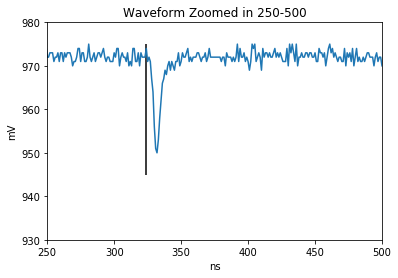

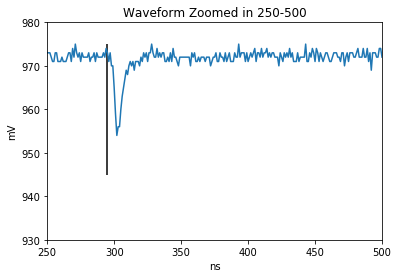

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

wf = ent[814]['Waveform']
eid = ent[814]['EventID']
ch = ent[814]['ChannelID']
pe = answ.query("EventID=={} & ChannelID=={}".format(eid, ch))
pev = pe['PETime'].values
unipe, c = np.unique(pev, return_counts=True)
plt.clf()
plt.xlim(250,500)
plt.ylim(930, 980)
tr = list(range(200, 500 + 1))
plt.plot(tr, wf[tr])
plt.vlines(unipe[0], ymin=945, ymax=975)
plt.title('Waveform Zoomed in 250-500')
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

wf = ent[626]['Waveform']
eid = ent[626]['EventID']
ch = ent[626]['ChannelID']
pe = answ.query("EventID=={} & ChannelID=={}".format(eid, ch))
pev = pe['PETime'].values
unipe, c = np.unique(pev, return_counts=True)
plt.clf()
plt.xlim(250,500)
plt.ylim(930, 980)
tr = list(range(200, 500 + 1))
plt.plot(tr, wf[tr])
plt.vlines(unipe[0], ymin=945, ymax=975)
plt.title('Waveform Zoomed in 250-500')
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()
ztrfile.close()

* * *
## 2.*梯度下降法拟合参数*

### 模块及文件路径导入

In [7]:
import numpy as np
import tensorflow as tf
import h5py

fipt = "/Users/xudachengthu/Downloads/GHdataset/finalcontest_data/ztraining-0.h5"
#fipt = "/Users/xudachengthu/Downloads/GHdataset/finalcontest_data/zincm-problem.h5"
fopt = "/Users/xudachengthu/Downloads/GHdataset/submission/first-submission-spe-fin.h5"
single_pe_path_old = '/Users/xudachengthu/Downloads/GH_LargeDoc/single_pe.h5'

### 神经网络基础参数设定

In [8]:
LEARNING_RATE = 0.005
STEPS = 1000
Length_pe = 1029
KNIFE = 0.1

### 定义数据格式

In [9]:
opd = [('EventID', '<i8'), ('ChannelID', '<i2'), ('PETime', 'f4'), ('Weight', 'f4')]

### 提取标准响应模型

In [10]:
speFile = h5py.File(single_pe_path_old, 'r')
spemean = np.mean(speFile['Sketchy']['speWf'], axis = 0)

#计算波形数据中电压的基线，进行波形反转
base_vol = np.mean(spemean[70:120])
stdmodel = np.subtract(base_vol, spemean[20:120])
#避免出现负数并减小波动
stdmodel = np.multiply(np.around(np.divide(stdmodel, 0.05)), 0.05)
stdmodel = np.abs(np.where(stdmodel >= 0, stdmodel, 0))

speFile.close()
model = stdmodel

### 生成标准响应模型矩阵

In [11]:
mtray = np.concatenate((np.zeros(Length_pe), model[0 : 50], np.zeros(Length_pe)))
loperator = np.concatenate([mtray[Length_pe - i : 2 * Length_pe + 50 - i] 
                            for i in range(Length_pe)]).reshape(Length_pe, Length_pe + 50)

### 路径配置

In [12]:
ipt = h5py.File(fipt, 'r')
opt = h5py.File(fopt, "w")

ent = ipt['Waveform']
dt = np.zeros(Length_pe, dtype = opd)
start = 0
end = 0

### 神经网络配置及训练

In [13]:
with tf.Graph().as_default():
    y_ = tf.placeholder(tf.float32, shape = (1, Length_pe + 50))
    LO = tf.placeholder(tf.float32, shape = (Length_pe, Length_pe + 50))
    w = tf.Variable(tf.random_uniform([1, Length_pe], minval = 0.0, maxval = 1.0))
    wsq = tf.multiply(w, w)
    y = tf.matmul(wsq, LO)
    loss = tf.reduce_mean(tf.square(y_ - y))
    train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)
    
    wf = ent[1]['Waveform']
    #wf = wf.reshape(1, len(wf))
    #计算波形中的基线，进行反转
    wf_input = (np.mean(wf[900:1000]) - wf)
    wf_input = np.concatenate((wf_input, np.zeros((1, 50))[0, :])).reshape(1, Length_pe + 50)
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

        for k in range(STEPS):
            _, loss_value, w_val, wsq_val, L, y_value = sess.run([train_step, loss, w, wsq, LO, y], 
                                                                 feed_dict = {LO : loperator, y_ : wf_input})
            if k == 0:
                print("Initial loss is {0:^7.3f}.".format(loss_value))
            if (k + 1) % 100 == 0:
                print("After {0:>4} training step(s), loss is {1:>7}.".format(k + 1, 
                                                                              "{0:.3f}".format(loss_value)))

Initial loss is 2627.675.
After  100 training step(s), loss is   4.774.
After  200 training step(s), loss is   2.458.
After  300 training step(s), loss is   1.897.
After  400 training step(s), loss is   1.645.
After  500 training step(s), loss is   1.497.
After  600 training step(s), loss is   1.399.
After  700 training step(s), loss is   1.330.
After  800 training step(s), loss is   1.278.
After  900 training step(s), loss is   1.239.
After 1000 training step(s), loss is   1.207.


### 简析利用神经网络进行参数拟合原理

#### 矩阵相乘相当于卷积

假设
1. 波形长度为5
2. 标准响应为

$$ h(n) = \left( \begin{array}{c} 0 & 2 & 1 \end{array} \right)  $$

如果预测的光电子入射时间的概率分布为

$$ x(n) = \left( \begin{array}{c} 1.0 & 1.4 & 0 & 0 & 0 \end{array} \right) $$

则期望的波形变化为

$$ \left( {\begin{array}{*{20}c} 1.0 & 1.4 & 0 & 0 & 0 \end{array}} \right) \times \left( {\begin{array}{*{20}c} 0 & 2 & 1 & 0 & 0\\ 0 & 0 & 2 & 1 & 0\\ 0 & 0 & 0 & 2 & 1\\ 0 & 0 & 0 & 0 & 2\\ 0 & 0 & 0 & 0 & 0 \\ \end{array}} \right) = \left( {\begin{array}{*{20}c} 0 & 2.0 & 3.8 & 1.4 & 0 \end{array}} \right) $$

即为卷积公式

$$ y(n)=\sum_{m=0}^{5} x(m)\,h(n-m)=x(n) * h(n) $$

的矩阵形式

但是由于噪声，不得不延长在响应模型生成的矩阵至 size = [5, 7]

$$ \left( {\begin{array}{*{20}c} 1.0 & 1.4 & 0 & 0 & 0 \end{array}} \right) \times \left( {\begin{array}{*{20}c} 0 & 2 & 1 & 0 & 0 & 0 & 0\\ 0 & 0 & 2 & 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 2 & 1 & 0 & 0\\ 0 & 0 & 0 & 0 & 2 & 1 & 0\\ 0 & 0 & 0 & 0 & 0 & 2 & 1\\ \end{array}} \right) = \left( {\begin{array}{*{20}c} 0 & 2.0 & 3.8 & 1.4 & 0 & 0 & 0 \end{array}} \right) $$

#### 在实际构建的神经网络中
1. 首先定义size为 [1, 1029] 的矩阵 w 
2. 为避免概率分布中出现负数，再将 w 同自己按元素相乘，得到size为 [1, 1029] 的矩阵 wsq 
3. 最后用矩阵 wsq 与 *标准响应模型矩阵* LO (size = [1029, 1079])，相乘得到预测波形 y_ 。
即：

$$ \underbrace{\left[1, 1029\right]}_{w} \cdot \underbrace{\left[1, 1029\right]}_{w} \rightarrow \underbrace{\left[1, 1029\right]}_{wsq} $$

$$ \underbrace{\left[1, 1029\right]}_{wsq} \times \underbrace{\left[1029, 1079\right]}_{LO} \rightarrow  \underbrace{\left[1, 1079\right]}_{y\_} $$

利用神经网络的梯度下降方法多次循环训练w的参数

### 去除过小的分布值

In [14]:
pf = wsq_val[0 : Length_pe]
pf = np.where(pf > KNIFE, pf, 0)

lenpf = np.size(np.where(pf > 0))
if lenpf == 0:
    pf[300] = 1

### 存储数据

In [15]:
pet = np.where(pf > 0)[1]
lenpf = np.size(pet)
pwe = pf[pf > 0]
end = start + lenpf

dt['PETime'][start:end] = pet
dt['Weight'][start:end] = pwe
dt['EventID'][start:end] = ent[0]['EventID']
dt['ChannelID'][start:end] = ent[0]['ChannelID']
start = end
    
dt = dt[np.where(dt['Weight'] > 0)]
opt.create_dataset('Answer', data = dt, compression='gzip')

ipt.close()
opt.close()

* * *
## 标准响应模型

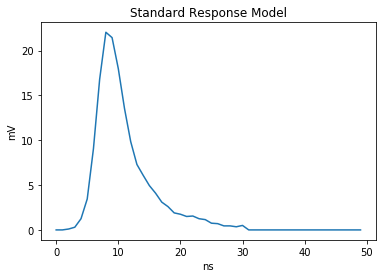

In [16]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(model[0:50])
plt.title("Standard Response Model")
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

## 生成的概率分布

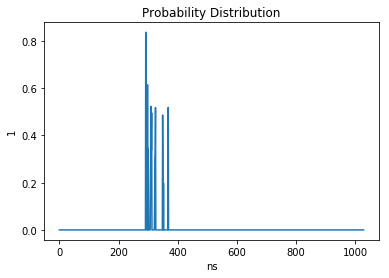

In [17]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(pf[0, :])
plt.title("Probability Distribution")
plt.xlabel('ns')
plt.ylabel('1')
plt.show()

## 真实的分布

[294 294 300 310 313 325 351 369]


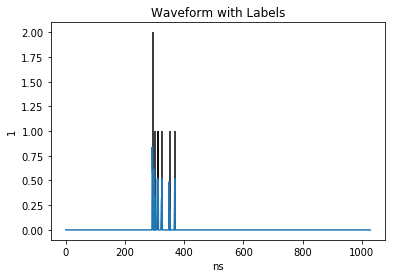

In [18]:
import pandas as pd
import h5py
ipt = h5py.File(fipt, 'r')
ent = ipt['Waveform'][0 : 1000]

eid = ent[1]['EventID']
ch = ent[1]['ChannelID']
th = pd.read_hdf(fipt,"GroundTruth")
rh = th[0 : 2000]
pe = th.query("EventID=={} & ChannelID=={}".format(eid, ch))

ipt.close()
pt = pe['PETime'].values
unique, c = np.unique(pt, return_counts = True)
#pt = pt[(pt >= 200) & (pt < 500)]
plt.xlim((0, 1029))
print(pt)

plt.clf()
plt.vlines(unique, ymin = 0, ymax = c)
plt.plot(pf[0, :])
plt.title("Waveform with Labels")
plt.xlabel('ns')
plt.ylabel('1')
plt.show()

## 原始波形和基于标准响应模型的预测波形之间的比较

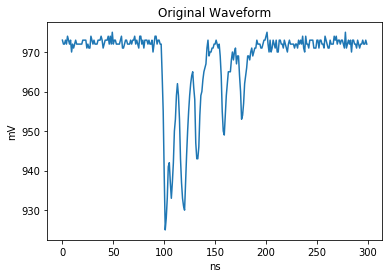

In [19]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(wf[200:500])
plt.title("Original Waveform")
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

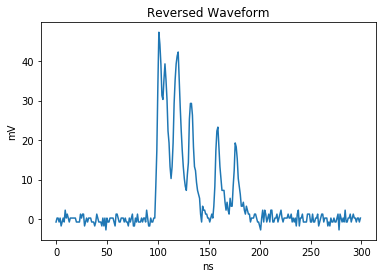

In [20]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot((np.mean(wf[900:1000]) - wf)[200:500])
plt.title("Reversed Waveform")
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

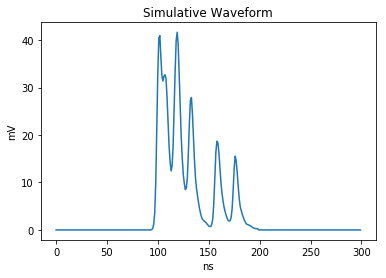

In [21]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.matmul(pf, loperator)[0, 200 : 500])
plt.title("Simulative Waveform")
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

In [22]:
exit()

* * *
## 备注

1. 此方法的W-dist统计值多在 3.5 - 4.1 之间
2. 在实际的程序中，利用tensorflow的特性，可以每次训练多条波形
3. 在实际过程中，发现电压波动多集中在[200 : 600]的范围内，在实际操作时，牺牲一些准确度，可以只取一小段波形进行参数拟合
4. 参数拟合所取的基础参数均可以用穷举法求出最优组合

## 优点

1. 模型清晰，预测波形和实际输入波形相似程度高
2. 参数拟合过程程序简洁

## 缺点

1. 训练时间过长，对1,605,330条波形，使用实验室服务器（CPU: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz），所需时间为21小时左右
2. 未考察各channel的特异性

## 改进的方向

1. 寻找响应模型的模式，对响应模型进行分类
2. 缩短训练时间
3. 考察各channel的特异性
4. 使用多模型进行参数拟合，以避免电压变化的模式的统计涨落对结果的不良影响，并尽量按整数拟合
5. 消除波形(waveform)中的噪声